In [3]:
# Install monai and matplotlib requirements
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib

# Install segmentation-models-3D
!pip install segmentation-models-3D

# Install classification-models-3d
!pip install classification-models-3d

# Install efficientnet-3d
!pip install efficientnet-3d

# Install patchify
!pip install patchify

# Set matplotlib backend
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Data handling
import numpy as np
import pandas as pd
import os
import shutil
import tempfile
import time


# Visualization
import matplotlib.pyplot as plt
from skimage import io

# Medical image processing
import nibabel as nib
import segmentation_models_3D as sm
from monai.apps import DecathlonDataset, CrossValidation
from monai.data import DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import SegResNet, UNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
)
from monai.utils import set_determinism

# Machine learning frameworks
import torch
import tensorflow as tf
import keras

from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
import nibabel as nib
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


# Data preprocessing
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset

Segmentation Models: using `tf.keras` framework.


In [3]:
root_dir =  "./"

In [4]:
# Transforms used to convert brain tumor labels as defined by Project MONAI Github
# https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb
# Reference: Project-MONOAI/tutorials

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):

    # Takes BraTS classes and gives them labels(1,2,3)
    # 1 is peritumoral edema
    # 2 is GD-enhancing tumor
    # 3 is non-enhancing tumor


    # TC_mask is 2 and 3 merged
    # WT mask is 1, 2, and 3 merged 
    # ET is 2

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
           
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
           
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
     
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [5]:
# These set of transforms were originally used by the Project-MONAI 3d segmentation tutorials. Link here: 
# https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb
# Reference: Project-MONOAI/tutorials

train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"],pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"],pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

/usr/local/lib/python3.9/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [6]:
# Load the datasets with DecathlonDataset
# Reference: Project-MONOAI/tutorials

train_ds = CrossValidation(
    dataset_cls=DecathlonDataset,
    nfolds=5,
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    progress=True,
    cache_rate=0.0,
    num_workers=2,
)

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=True,
    progress=True,
    cache_rate=0.0,
    num_workers=2,
)

Task01_BrainTumour.tar: 7.09GB [05:16, 24.0MB/s]                            

2023-04-24 23:06:11,982 - INFO - Downloaded: Task01_BrainTumour.tar


2023-04-24 23:06:26,411 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-04-24 23:06:26,413 - INFO - Writing into directory: ..


/usr/local/lib/python3.9/dist-packages/monai/transforms/spatial/array.py:577: UserWarning: `data_array` is not of type `MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type `MetaTensor, assuming affine to be identity.")


image shape: torch.Size([4, 240, 240, 155])


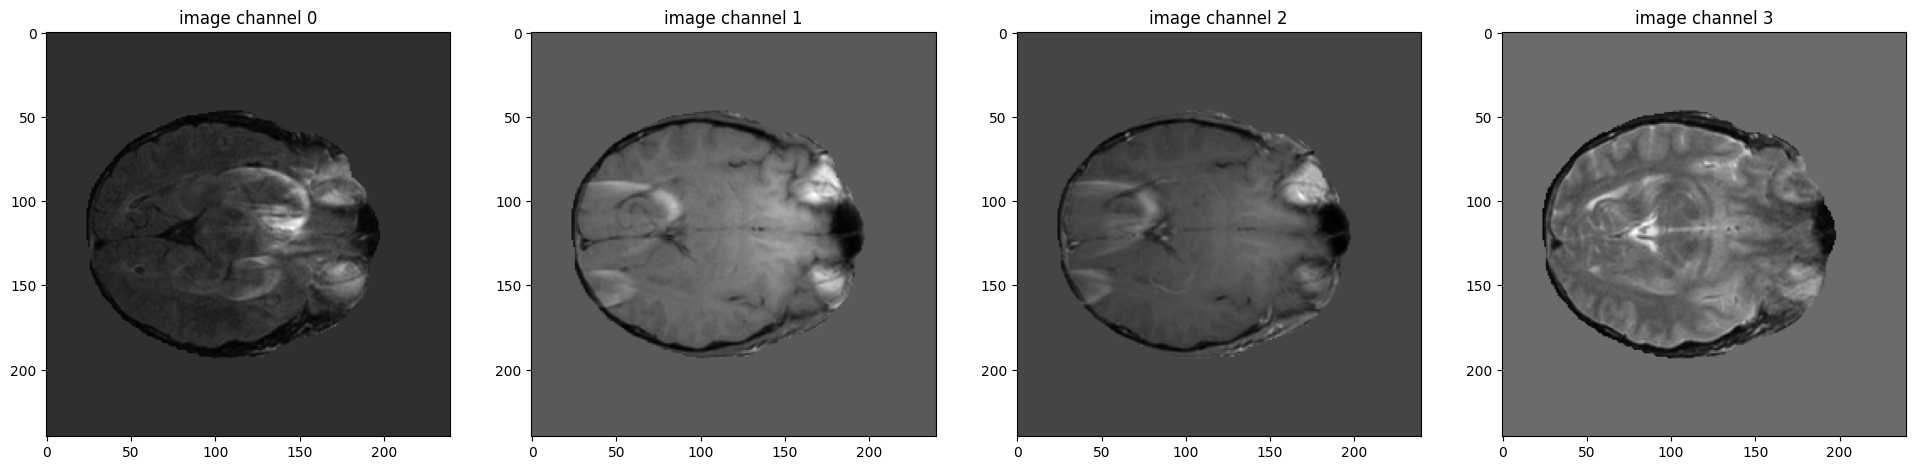

label shape: torch.Size([3, 240, 240, 155])


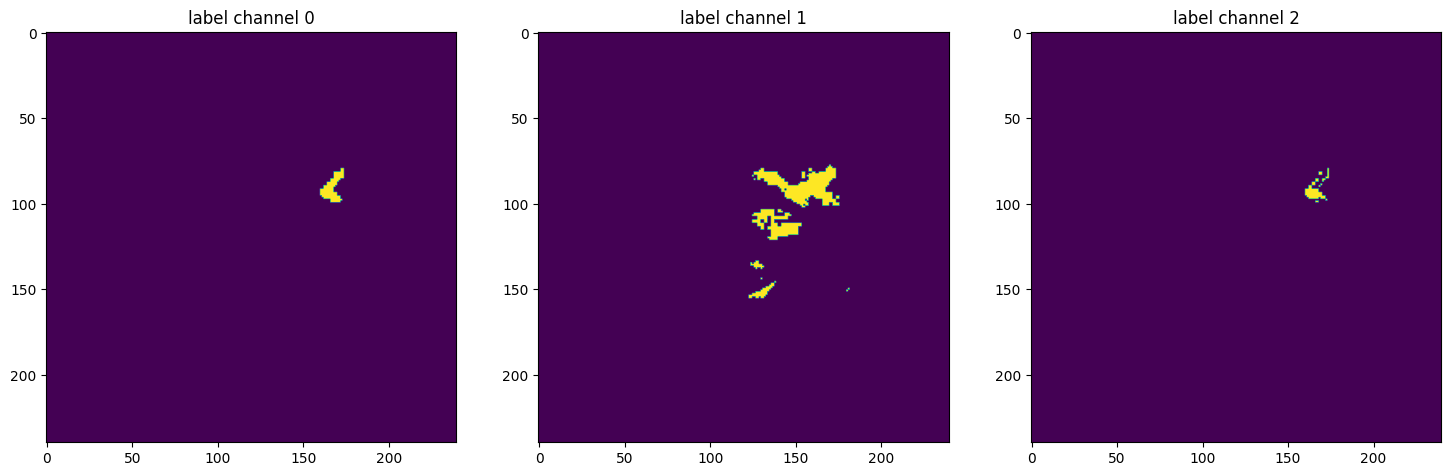

In [7]:
# Data visualization and shape
# Reference: Project-MONOAI/tutorials 

data_example = val_ds[10] 
print(f"image shape: {data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()

print(f"label shape: {data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

In [8]:
# Loss and Optimizer
# Reference: Project-MONOAI/tutorials
# https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb  

max_epochs = 3
val_interval = 1
batches_per_epoch = None
batch_size = 1
num_of_folds=3
VAL_AMP = True

# Use gpu
device = torch.device("cuda:0")

# dice loss function 
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

# have the dice score include the background region for false positives
dice_metric = DiceMetric(include_background=True, reduction="mean")

# calculation over epochs
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

#hausdorff metric 95%
hausdorff95_metric = HausdorffDistanceMetric(include_background=True, percentile=.95, reduction="mean")
hausdorff95_metric_batch = HausdorffDistanceMetric(include_background=True, percentile=.95, reduction="mean_batch")
post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# As defined by MONOAI tutorial 
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)



scaler = torch.cuda.amp.GradScaler()

torch.backends.cudnn.benchmark = True

# We need to turn shuffle = True so folds are mixed 
k_fold = KFold(n_splits=num_of_folds,shuffle=True,random_state=10)
path_to_best_model = "saved_model.h5"

In [10]:
dice_loss_over_epoch = [[] for _ in range(num_of_folds)]
dice_scores = [[] for _ in range(num_of_folds)]
hausdorff95_distances = [[] for _ in range(num_of_folds)]

In [12]:
total_start = time.time()
for fold in range(num_of_folds):
    
    print(f'Starting Fold #{fold + 1}')
    
    model = UNet(
        spatial_dims=3,
        in_channels=4,
        out_channels=3,
        channels=(8, 16, 32, 64),
        strides=(1,1,1),
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
    folds = [k for k in range(5)]
    folds.remove(fold)
    train_set = train_ds.get_dataset(folds=folds)
    val_set = train_ds.get_dataset(folds=fold)
    train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=2)
    
    with tqdm(train_loader, unit="batch") as tepoch:
      for epoch in range(max_epochs):
          epoch_start = time.time()
          print("-" * 10)
          print(f"epoch {epoch + 1}/{max_epochs}")
        
          # D = train_model(model, train_loader, loss_function, optimizer, lr_scheduler)

          model.train()
          epoch_loss = 0
          step = 0

          for batch_data in train_loader:
              step += 1
              step_start = time.time()
              inputs, labels = (
                  batch_data["image"].to(device),
                  batch_data["label"].to(device),
              )
              optimizer.zero_grad()
              with torch.cuda.amp.autocast():
                  outputs = model(inputs)
                  loss = loss_function(outputs, labels)
              scaler.scale(loss).backward()
              scaler.step(optimizer)
              scaler.update()
              epoch_loss += loss.item()
              #print(
              #    f" Step #{step}",
              #    f", train_loss: {loss.item():.4f}"
              #    f", step time: {(time.time() - step_start):.4f}"
              #)
          lr_scheduler.step()
          epoch_loss /= step
          print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
          
          D = epoch_loss

          dice_loss_over_epoch[fold].append(D)
          if (epoch + 1) % val_interval == 0:
              
              # D, H = val_model(model, val_loader, optimizer)
              
              D_best_metric = -1
              D_metric_values = []
              
              H_metric_values = []
              
              model.eval()
              with torch.no_grad():
                  step = 0
                  for val_data in val_loader:
                      step += 1
                      val_inputs, val_labels = (
                          val_data["image"].to(device),
                          val_data["label"].to(device),
                      )
                      val_outputs = inference(val_inputs)
                      val_outputs = post_trans(val_outputs)
                      dice_metric(y_pred=val_outputs, y=val_labels)
                      dice_metric_batch(y_pred=val_outputs, y=val_labels)
                      hausdorff95_metric(y_pred=val_outputs, y=val_labels)
                      hausdorff95_metric_batch(y_pred=val_outputs, y=val_labels)

                  D_metric = dice_metric.aggregate().item()
                  print(D_metric)
                  D_metric_batch = dice_metric_batch.aggregate()
                  dice_metric.reset()
                  dice_metric_batch.reset()

                  H_metric = hausdorff95_metric.aggregate().item()
                  H_metric_batch = hausdorff95_metric_batch.aggregate()
                  hausdorff95_metric.reset()
                  hausdorff95_metric_batch.reset()

                  if D_metric > D_best_metric:
                      D_best_metric = D_metric
                      
                      torch.save(
                          model.state_dict(),
                          os.path.join(root_dir, path_to_best_model),
                      )
                      print("saved new best metric model")

              D = D_metric
              H = H_metric
              
              dice_scores[fold].append(D)
              hausdorff95_distances[fold].append(H)
              print(f"Validation mean dice: {D:.4f}")
              print(f"best mean dice: {min(dice_scores[fold]):.4f}")
              print(f"Validation mean hausdorff distance: {H}")

          print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

Starting Fold #1
2023-04-24 23:16:58,791 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-04-24 23:16:58,792 - INFO - File exists: Task01_BrainTumour.tar, skipped downloading.
2023-04-24 23:16:58,794 - INFO - Non-empty folder exists in Task01_BrainTumour, skipped extracting.
2023-04-24 23:17:13,253 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-04-24 23:17:13,255 - INFO - File exists: Task01_BrainTumour.tar, skipped downloading.
2023-04-24 23:17:13,256 - INFO - Non-empty folder exists in Task01_BrainTumour, skipped extracting.


  0%|          | 0/387 [00:00<?, ?batch/s]

----------
epoch 1/3
epoch 1 average loss: 0.8177
0.5754504203796387
saved new best metric model
Validation mean dice: 0.5755
best mean dice: 0.5755
Validation mean hausdorff distance: 0.09560704976320267
time consuming of epoch 1 is: 842.8057
----------
epoch 2/3
epoch 2 average loss: 0.4317
0.6336771249771118
saved new best metric model
Validation mean dice: 0.6337
best mean dice: 0.5755
Validation mean hausdorff distance: 0.02547839656472206
time consuming of epoch 2 is: 605.2610
----------
epoch 3/3
epoch 3 average loss: 0.3553


  0%|          | 0/387 [34:01<?, ?batch/s]

0.6493161916732788
saved new best metric model
Validation mean dice: 0.6493
best mean dice: 0.5755
Validation mean hausdorff distance: 0.02204197272658348
time consuming of epoch 3 is: 593.5055
Starting Fold #2


2023-04-24 23:51:29,252 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-04-24 23:51:29,253 - INFO - File exists: Task01_BrainTumour.tar, skipped downloading.
2023-04-24 23:51:29,255 - INFO - Non-empty folder exists in Task01_BrainTumour, skipped extracting.
2023-04-24 23:51:43,646 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-04-24 23:51:43,647 - INFO - File exists: Task01_BrainTumour.tar, skipped downloading.
2023-04-24 23:51:43,649 - INFO - Non-empty folder exists in Task01_BrainTumour, skipped extracting.


  0%|          | 0/387 [00:00<?, ?batch/s]

----------
epoch 1/3
epoch 1 average loss: 0.7779
0.5251350402832031
saved new best metric model
Validation mean dice: 0.5251
best mean dice: 0.5251
Validation mean hausdorff distance: 0.1896754801273346
time consuming of epoch 1 is: 782.3695
----------
epoch 2/3
epoch 2 average loss: 0.4157
0.6151849627494812
saved new best metric model
Validation mean dice: 0.6152
best mean dice: 0.5251
Validation mean hausdorff distance: 0.03299768269062042
time consuming of epoch 2 is: 627.3526
----------
epoch 3/3
epoch 3 average loss: 0.3410


  0%|          | 0/387 [34:01<?, ?batch/s]

0.6090569496154785
saved new best metric model
Validation mean dice: 0.6091
best mean dice: 0.5251
Validation mean hausdorff distance: 0.04894378408789635
time consuming of epoch 3 is: 631.7976
Starting Fold #3


2023-04-25 00:25:59,565 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-04-25 00:25:59,566 - INFO - File exists: Task01_BrainTumour.tar, skipped downloading.
2023-04-25 00:25:59,568 - INFO - Non-empty folder exists in Task01_BrainTumour, skipped extracting.
2023-04-25 00:26:14,005 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-04-25 00:26:14,007 - INFO - File exists: Task01_BrainTumour.tar, skipped downloading.
2023-04-25 00:26:14,008 - INFO - Non-empty folder exists in Task01_BrainTumour, skipped extracting.


  0%|          | 0/387 [00:00<?, ?batch/s]

----------
epoch 1/3
epoch 1 average loss: 0.7836
0.5107325911521912
saved new best metric model
Validation mean dice: 0.5107
best mean dice: 0.5107
Validation mean hausdorff distance: 0.1654699593782425
time consuming of epoch 1 is: 783.3592
----------
epoch 2/3
epoch 2 average loss: 0.4203
0.5826581716537476
saved new best metric model
Validation mean dice: 0.5827
best mean dice: 0.5107
Validation mean hausdorff distance: 0.04367533326148987
time consuming of epoch 2 is: 607.2142
----------
epoch 3/3
epoch 3 average loss: 0.3454


  0%|          | 0/387 [33:59<?, ?batch/s]

0.6187379360198975
saved new best metric model
Validation mean dice: 0.6187
best mean dice: 0.5107
Validation mean hausdorff distance: 0.026135915890336037
time consuming of epoch 3 is: 649.2126


In [ ]:
D_best_metric = np.amin(np.array(D_metric_values))
H_best_metric = np.amin(np.array(H_metric_values))

In [ ]:
print(f"train completed, Dice best metric: {D_best_metric:.4f}, total time: {total_time}.")
average = np.average([np.min(D) for D in D_metric_values])
print(f"Average Dice Score {average:.4f}")

for fold in range(len(D_metric_values)):
    print(f"Fold #{fold+1}: {np.min(D_metric_values[fold]):.4f}")

In [ ]:
# Referenced https://www.kaggle.com/code/instrikeronetwo/cap5516-a2/notebook

plt.figure("Dice Scores", (12,6))
plt.subplot(1,2,1)
plt.title("Epoch Average Dice Loss")
plt.xlabel("epoch")
for fold, y in enumerate(D_epoch_loss_values):
    x = [i + 1 for i in range(len(y))]
    plt.plot(x, y, label=f'Fold #{fold+1}')
plt.legend()
    
plt.subplot(1,2,2)
plt.title(f"Val Mean Dice")
plt.xlabel("epoch")    
for fold, y in enumerate(D_metric_values):
    x = [val_interval * (i + 1) for i in range(len(y))]
    plt.plot(x, y, label=f'Fold #{fold+1}')
plt.legend()
plt.show()

In [ ]:
plt.figure("Dice Scores", (6,6))
plt.title(f"Val Mean Hausdorff Distance")
plt.xlabel("epoch")    
for fold, y in enumerate(H_metric_values):
    x = [val_interval * (i + 1) for i in range(len(y))]
    plt.plot(x, y, label=f'Fold #{fold+1}')
plt.legend()
plt.show()